# MCRL for article

In [53]:
import numpy as np
import random
import math 

In [54]:
z = 10 #Degradation threshold

def state(amount):
    new_state = []    
    if (amount >= 0 and amount <2):
        new_state = 0 # healthy1
    
    if (amount >= 2 and amount <7):
        new_state = 1 # healthy2
        
    if (amount >= 7 and amount < z ):
        new_state = 2 #healthy3 
        
    if (amount >= z):
        new_state = 3 # fail
    
    return new_state

In [55]:
def Rewardfun(degradation):
    Reward=np.zeros((4,)+(3,))
    Reward[: , 0] = -50
    Reward[3,0] = -1050
    Reward[: , 1] = -500*(degradation/z)-50
    Reward[3,1] = -1150
    Reward[: , 2] = -550
    Reward[3,2] = -1550
       
    return Reward

In [56]:
def possible_action(state):
    if state == 0 :
        return [0,1]
    if state == 1 :
        return [0,1,2]
    if state == 2:
        return [0,1,2]
    if state == 3:
        return [2]

In [57]:
possible_action(3)

[2]

In [58]:
len(possible_action(2))

3

In [59]:
def Envirenment(degradation , action,a):
   
    n2 = np.random.poisson((1-0.001)*4, 1) # number of effective shock
    w2 = np.random.gamma(0.6, 1.2, n2) # magnitude of effective shock
    magnitude = sum(w2)
    next_state = 0
    reward = 0
    
    if action == 0 :#do nothing
        
            degradation += (magnitude + 3)/a
            next_state=state(degradation)
            Reward=Rewardfun(degradation)
            reward=Reward[next_state,action]
        
    if action == 1 : #repair
        
           # decay = degradation*np.random.beta(0.5, 1, 1)
            #decay = degradation/z
            #degradation -= decay*degradation
            degradation = np.max((0.05, degradation))
            decay =(np.random.gamma(degradation*degradation/2,2/(degradation),1)/z)[0]
            degradation -= np.max((0, decay*degradation))
            degradation = np.max((0.05, degradation))
            degradation += (magnitude + 2.95)/a
            next_state=state(degradation)
            Reward=Rewardfun(degradation)
            reward=Reward[next_state,action]
                    
    if action == 2 : # replace
        
            degradation = (magnitude + 2.85)/a
            next_state=state(degradation)
            Reward=Rewardfun(degradation)
            reward=Reward[next_state,action]
       
    
    return next_state , reward , degradation


In [60]:
Envirenment(6.929383290900782 , 1,8)

(1, -215.9686245540393, 3.319372491080786)

# pi function 

In [61]:
def policy_using_pi(state, pi):
    return np.random.choice(possible_action(state), p=[pi[(state,a)] for a in possible_action(state)])

In [62]:
#np.zeros((4,3))
#np.array([[0.5,0.5,0],[0.33,0.34,0.33],[0.33,0.33,0.34],[0,0,1]])
pi = np.array([[0.7,0.3,0],[0.34,0.33,0.33],[0.33,0.34,0.33],[0,0,1]])

In [63]:
policy_using_pi(0, pi)

0

In [64]:
def choose_action(current_state, pi):
    return policy_using_pi(current_state, pi)  #epsilon_soft       

# Episode Function

In [65]:
GAMMA =  0.5
def play_episode(pi):
    #S0,A0,R1,S1,A1,R2,S2,A2,R3 ,...
    #s = 0 #it is new
    #d = 0 #it is new
    
    d = np.random.uniform(0 , 10) #random
    s = state(d)
    a= choose_action(s, pi)
    
    #r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
    states_actions_rewards = [((s, a, 0))]
    
    for j in range(100 +1):
    
        s , r ,d  = Envirenment(d,a,8)
        if (j == 100):
            states_actions_rewards.append((s, None, r))
        else:
            a= choose_action(s, pi)
            states_actions_rewards.append((s,a, r))
            
    
     # calculate the returns by working backwards from the terminal state
    G = 0
    states_actions_returns = []
    first = True
    for s, a, r in reversed(states_actions_rewards):
        
       # the value of the terminal state is 0 by definition
       # we should ignore the first state we encounter
        # and ignore the last G, which is meaningless since it doesn't correspond to any move
        if first:
            first = False
        else:
            states_actions_returns.append((s, a, G))
        G = r + GAMMA*G
    
    return states_actions_returns 


In [66]:
#pi = np.array([[0.99,0.01,0],[0.34,0.33,0.33],[0.33,0.34,0.33],[0,0,1]])
#play_episode_F(pi)

In [67]:
#print(np.full((4,3), 0.5)) 
#print(np.zeros((4, ) + (3,)))

In [68]:
def epsilon_rate(t):
    
    """Gets value for learning rate. It declines as we advance in episodes."""
    # Learning rate also declines as we add more episodes
    return max(minepsilon, min(1., 1. - math.log10((t + 1) / decay)))


In [69]:
minepsilon = 0.00001
decay = 10

In [70]:
np.random.uniform(0 , 10)

7.573620290359435

# Run all episodes

In [71]:
def counter_state_action(counter_matrix, state_action):
    counter_matrix[state_action] += 1
    return counter_matrix

In [72]:
counter_matrix = np.zeros((4,3))

In [73]:
counter_state_action(counter_matrix, (1,0))

array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [74]:
epsilon = 1
learning_rate = 1
pi = np.array([[0.99,0.01,0],[0.34,0.33,0.33],[0.33,0.34,0.33],[0,0,1]])
Q = np.zeros((4, ) + (3,))
old_Q = 0 

counter_matrix = np.zeros((4,3))

Q[3,0]= -100000000
Q[3,1]= -100000000
Q[0,2]= -100000000

returns =np.zeros((4,) + (3,))
N = np.zeros((4 ,) + (3,))

deltas = []


for epi in range(600 +1):# Looping through episodes 
    
    # generate an episode using pi
    biggest_change = 0
    states_actions_returns = play_episode(pi)
    
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
        # check if we have already seen s
        # called "first-visit" MC policy evaluation
    
        state_action = (s,a)
        
        if state_action not in seen_state_action_pairs:
        #if 1 == 1:   
            returns[s][a] += G
            N[s][a] +=1
            old_Q = Q[s][a]    
            Q[s][a] = returns[s][a] /N[s][a] # Average reward across episodes
            
            biggest_change = max(biggest_change, np.abs(old_Q - Q[s][a]))
            seen_state_action_pairs.add(state_action)
            
            counter_state_action(counter_matrix, state_action)
              
            #for each s in the episode         
            A_star = np.argmax(Q[s])# Finding the action with maximum value 
            
            for a in possible_action(s): # Update action probability 
                if a == A_star:
                    pi[(s,a)] = 1 - epsilon + (epsilon / len(possible_action(s)))
                else:
                    pi[(s,a)] = (epsilon / len(possible_action(s)))
                     
    
    learning_rate *= 0.99
    epsilon *= 0.99  
    #epsilon = epsilon_rate(epi)
    #eps = epsilon - 0.0005
    #epsilon = max (0, eps)
    deltas.append(biggest_change)
                  

In [75]:
counter_matrix

array([[599., 231.,   0.],
       [601., 382., 376.],
       [125., 564., 125.],
       [  0.,   0.,  12.]])

In [76]:
print(epsilon)
print (Q)
print(pi)

0.0023809591983979563
[[-1.04322749e+02 -2.15949178e+02 -1.00000000e+08]
 [-1.11508233e+02 -2.83165011e+02 -6.01037235e+02]
 [-2.62851827e+02 -2.43246654e+02 -6.20147939e+02]
 [-1.00000000e+08 -1.00000000e+08 -6.11820093e+02]]
[[9.98797495e-01 1.20250465e-03 0.00000000e+00]
 [9.98396660e-01 8.01669764e-04 8.01669764e-04]
 [8.01669764e-04 9.98396660e-01 8.01669764e-04]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


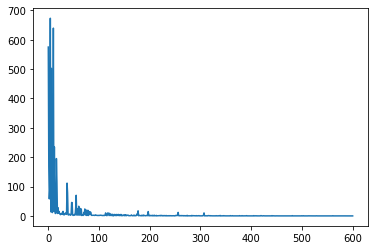

In [77]:
import matplotlib.pyplot as plt
plt.plot(deltas)
plt.show()

In [78]:
optimal_value =[]
current_state = 0 #it is new
degradation = 0
optimal_cost = []
expected_optimal_cost=[]
num=[]
numm =[]

        
for j in range(2000+1):
    #Choose A from S
    action = np.argmax(Q[current_state])
    if action == 1:
        optimal_value.append(degradation) 
        num.append(j)
    
    numm =[3*num[i] - 3*num[i-1] for i in range(1, len(num))]
    #print(num , numm)
    # Take action
    current_state, reward ,degradation_new = Envirenment(degradation,action,8)
    optimal_cost.append(-reward)
    #print ("degradation =" + str(degradation), "action"+ str(action),
          #"Reward"+str(reward), "new degradation =" + str(degradation_new))
    degradation = degradation_new
    #print(optimal_cost)
    #if any(np.array(optimal_cost) > 50) and any(np.array(optimal_cost) < 550) :
        #expected_optimal_cost.append(np.mean(optimal_cost))
    if any(np.array(optimal_cost) > 50):
        expected_optimal_cost.append(np.mean(optimal_cost))
    if action ==1:
        optimal_cost = []
    
    
#print(optimal_value)
#print(".................")
#print(expected_optimal_cost)
#print(".................")
print("optimal degradation for repair=",np.mean(optimal_value))
#print(".................")
print("cost for repair =",np.mean(expected_optimal_cost))
print("Time for repair =",np.mean(numm))
#print("Time for repair =",numm)

optimal degradation for repair= 7.416066407123275
cost for repair = 70.06449415256039
Time for repair = 22.12639405204461
